In [1]:
import sys
sys.path.append('../utils')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from MiguelTK import *
import warnings
warnings.filterwarnings('ignore')
from sqlalchemy import create_engine

In [37]:
with open('./utils/ruta.txt') as doc:
    ruta = doc.read()

In [39]:
conn = create_engine(ruta).connect()

In [40]:
conn.execute('USE ropa_zara')

## Limpieza y transformación de datos

In [4]:
df = pd.read_sql('SELECT * FROM ropa;',con = conn)

In [5]:
df.head()

,extracción,articulo,precio,descripcion,grupo_web,tallas,colores,enlace,marca,grupo,seccion
0,2024-06-04 11:45:24.327275,PANTALÓN CHINO CINTURÓN,27.95,Pantalón de tiro alto con elástico en cintura....,V2024-MUJER-ULTIMA-SEMANA,"['XS', 'S', 'M', 'L', 'XL', 'XXL']","['Marino', 'Tostado']",https://www.zara.com/es/es/pantalon-chino-cint...,ZARA,PANTALÓN,MUJER
1,2024-06-04 11:45:24.327275,VESTIDO CORTO CUT OUT,25.95,Vestido corto de cuello halter. Detalle de abe...,V2024-MUJER-ULTIMA-SEMANA,"['XS', 'S', 'M', 'L', 'XL', 'XXL']",[],https://www.zara.com/es/es/vestido-corto-cut-o...,ZARA,VESTIDO,MUJER
2,2024-06-04 11:45:24.327275,TOP CROPPED VOLANTES,22.95,Top de escote asimétrico y tirante fino. Bajo ...,V2024-MUJER-ULTIMA-SEMANA,"['XS', 'S', 'M', 'L', 'XL']",[],https://www.zara.com/es/es/top-cropped-volante...,ZARA,TOP,MUJER
3,2024-06-04 11:45:24.327275,ORCHID 180 ML,15.95,ZARA ORCHID EAU DE PARFUM 180 ML (6.0 FL. OZ)....,V2024-MUJER-ULTIMA-SEMANA,[],[],https://www.zara.com/es/es/orchid-180-ml-p2012...,ZARA,ORCHID,MUJER
4,2024-06-04 11:45:24.327275,VESTIDO MIDI DRAPEADO ZW COLLECTION,59.95,ZARA WOMAN COLLECTIONVestido midi confeccionad...,V2024-MUJER-ULTIMA-SEMANA,"['XS', 'S', 'M', 'L']",[],https://www.zara.com/es/es/vestido-midi-drapea...,ZARA,VESTIDO,MUJER


In [ ]:
## Como la esctracción se ha hecho en diversas fechas, hay prendas repetidas, se van a eliminar y nos quedamos con el registro más nuevo 


In [6]:
df['temporada'] = df['grupo_web'].str.extract(r'^(\w+)\-')
del df['grupo_web']

In [7]:
df['n_tallas'] = df['tallas'].str.count(r'\'(\w+)\'')

In [8]:
del df['enlace']

In [9]:
df['n_colores'] = df['colores'].str.count(r'\'(\w+)\'')

In [10]:
df['contiene_lino'] = df['descripcion'].str.contains(r'lino',case=False)

In [11]:
df['contiene_algodon'] = df['descripcion'].str.contains(r'algodón',case=False)

In [12]:
df['tipo_talla'] = (
    df['tallas']
    .str.contains(r'\d')
    .map({
        True:'numérica',
        False:'alfabética'
    })
)

In [13]:
df['colores'] = df['colores'].str.upper()

## Estudio de colores

In [14]:
tabla_colores = (
    df['colores']
    .str.replace(r'[\[\]\']','',regex=True)
    .str.replace(r'\,\s',',',regex=True)
    .str.split(',',expand=True)
    .assign(seccion = df['seccion'])
    .melt('seccion')
    .drop(columns='variable')
    .dropna(subset='value')
    .query('value != ""')
)
tabla_colores

,seccion,value
0,MUJER,MARINO
9,MUJER,VERDE
23,MUJER,AZUL MEDIO
25,MUJER,BLANCO
36,MUJER,BLANCO
...,...,...
67251,HOMBRE,ROSA EMPOLVADO
68066,MUJER,NEGRO
72094,NINOS,VERDE
77753,NINOS,NARANJA


In [15]:
B_N = (
    tabla_colores
    ['value']
    .str.contains(r'(NEGRO)|(BLANCO)',regex=True)
)

Colores más frecuentes por sección (diferentes al blanco y negro)


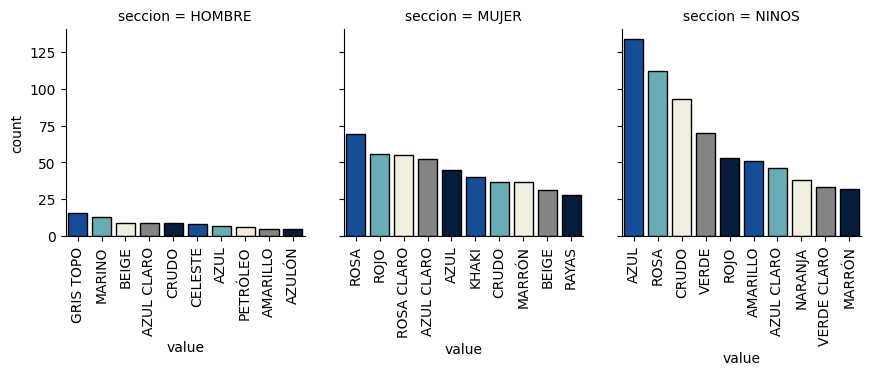

In [16]:
df_ = (
    tabla_colores[~B_N]
    .groupby('seccion',as_index=False)
    ['value']
    .value_counts()
    .groupby('seccion')
    .apply(lambda x: x.nlargest(10,'count'))
)
grid = sns.FacetGrid(df_,col='seccion',sharex=False)
grid.map(sns.barplot,'value','count',**kwargs)
grid.tick_params('x',rotation=90)
print('Colores más frecuentes por sección (diferentes al blanco y negro)')

In [17]:
df_ = (
    tabla_colores[~B_N]
    .groupby('seccion',as_index=False)
    ['value']
    .value_counts()
    .groupby('seccion')
    .apply(lambda x: x.nsmallest(10,'count'))
    .drop(columns='seccion')
    .reset_index()
    .drop(columns=['level_1','count'])
)
print('Colores menos frecuentes por sección (diferentes al blanco y negro)')
print(df_)

Colores menos frecuentes por sección (diferentes al blanco y negro)
   seccion           value
0   HOMBRE         CEMENTO
1   HOMBRE    KHAKI OSCURO
2   HOMBRE           VERDE
3   HOMBRE      VERDE GRIS
4   HOMBRE    ROJO BURDEOS
5   HOMBRE           RAYAS
6   HOMBRE           MUSGO
7   HOMBRE         VERDOSO
8   HOMBRE     VISÓN CLARO
9   HOMBRE       ROJO VIVO
10   MUJER   MARRÓN OSCURO
11   MUJER          MEDIUM
12   MUJER          MORADO
13   MUJER      MULTICOLOR
14   MUJER     AZUL PASTEL
15   MUJER  NARANJA OSCURO
16   MUJER           FRESA
17   MUJER   PEACH SHIMMER
18   MUJER     ARENA CLARO
19   MUJER     142 - TRUTH
20   NINOS           ROSAS
21   NINOS           FRESA
22   NINOS       FRAMBUESA
23   NINOS        BURGUNDY
24   NINOS            VINO
25   NINOS   VIOLETA MALVA
26   NINOS     MALVA CLARO
27   NINOS      ROJO CLARO
28   NINOS     ROJO OSCURO
29   NINOS          ÍNDIGO


<Axes: xlabel='seccion', ylabel='n_colores'>

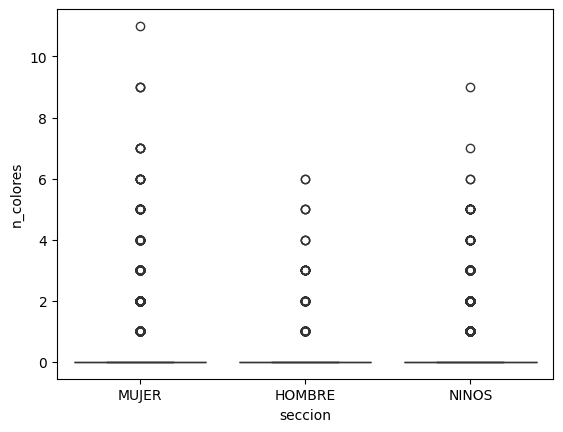

In [18]:
sns.boxplot(
    data = df,
    x = 'seccion',
    y = 'n_colores',
    palette = palette
)

La ropa masculina tiene mayor variedad en los colores disponibles.

## Estudio de composición

In [19]:
df['contiene_lino'].value_counts(normalize=True)

contiene_lino
False    0.922955
True     0.077045
Name: proportion, dtype: float64

El `11 %` de las prendas de ropa contienen lino

In [20]:
df['contiene_algodon'].value_counts(normalize=True)

contiene_algodon
False    0.908111
True     0.091889
Name: proportion, dtype: float64

El `15 %` de las prendas de ropa contienen algodón

In [21]:
pd.crosstab(
    df['contiene_lino'],
    df['seccion'],
    normalize='index'
)

seccion,HOMBRE,MUJER,NINOS
contiene_lino,,,
False,0.102049,0.404557,0.493395
True,0.130734,0.594037,0.275229


In [22]:
pd.crosstab(
    df['contiene_algodon'],
    df['seccion'],
    normalize='index'
)

seccion,HOMBRE,MUJER,NINOS
contiene_algodon,,,
False,0.088539,0.422845,0.488616
True,0.259615,0.382692,0.357692


Las prendas de ropa que contienen o bien lino o bien algodón tienen más posibilidades de ser de la sección masculina.

<Axes: xlabel='contiene_lino', ylabel='precio'>

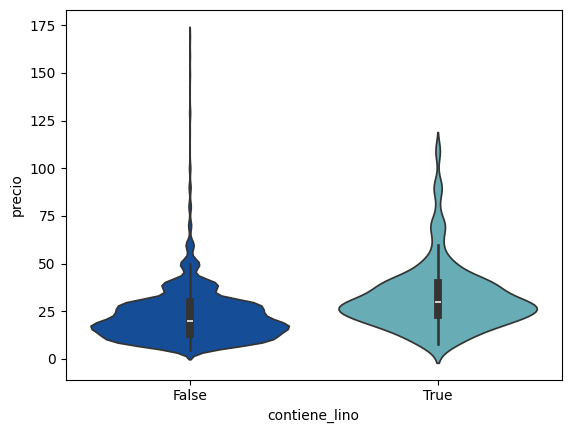

In [23]:
sns.violinplot(
    data = df,
    x = 'contiene_lino',
    y = 'precio',
    palette = palette
)

Las prendas que contienen `lino` pueden tener precios más altos que las que no lo contienen.

## Estudio de tallas

### Tallas extremas

#### Tallas letras

In [24]:
df_ = df.query('tipo_talla == "alfabética"')

In [25]:
pd.crosstab(
    df_['tallas'].str.contains('XS'),
    df_['seccion'],
    normalize = 'index'
)

seccion,HOMBRE,MUJER,NINOS
tallas,,,
False,0.288770,0.552807,0.158422
True,0.003779,0.988662,0.007559


In [26]:
pd.crosstab(
    df_['tallas'].str.contains('XL'),
    df_['seccion'],
    normalize = 'index'
)

seccion,HOMBRE,MUJER,NINOS
tallas,,,
False,0.080717,0.697758,0.221525
True,0.203638,0.796362,0.000000


In [27]:
pd.crosstab(
    df_['tallas'].str.contains('XXL'),
    df_['seccion'],
    normalize = 'index'
)

seccion,HOMBRE,MUJER,NINOS
tallas,,,
False,0.178987,0.718439,0.102575
True,0.014599,0.985401,0.000000


- Las prendas que tienen la talla `XS` disponible pertenecen casi todas a la sección femenina. 
- Las prendas con las talla `XL` disponible están en mayor equilibrio.
- Las prendas que tienen disponible la talla `XXL` pertenecen en mayor proporción a la sección femenina, y las que no tienen esa talla disponible son en su mayoría de caballero.

### Número de tallas disponibles

<Axes: xlabel='seccion', ylabel='n_tallas'>

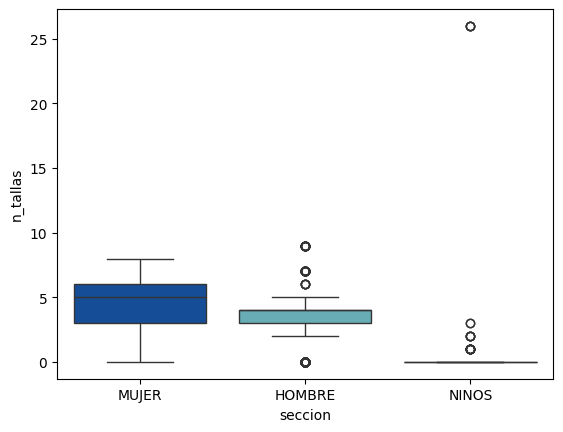

In [28]:
sns.boxplot(
    data = df,
    x = 'seccion',
    y = 'n_tallas',
    palette = palette
)

La ropa de la sección de mujer ofrece una mayor variedad de tallas.

## Palabras clave
porcentaje de prendas cuya descripción contiene la palabra clave:

In [29]:
# RELAXED
df['descripcion'].str.contains('relaxed',case=False).sum() / len(df)

0.02738999823290334

In [30]:
# FIT
df['descripcion'].str.contains('fit',case=False).sum() / len(df)

0.10196147729280791

In [31]:
# BRILLOS
df['descripcion'].str.contains(r'brillos?',case=False).sum() / len(df)

0.010779289627142604

In [32]:
# ESTAMPADO ANIMAL
df['descripcion'].str.contains(r'estampado\sanimal',case=False,regex=True).sum() / len(df)

0.004417741650468281

In [33]:
# ASIMÉTRICO
df['descripcion'].str.contains(r'asimétric[oa]',case=False).sum() / len(df)

0.013960063615479766

In [34]:
# OVERSIZE
df['descripcion'].str.contains(r'over\s?size',case=False).sum() / len(df)

0.004417741650468281

In [35]:
# EFECTO ARRUGADO
df['descripcion'].str.contains(r'efecto arrugado',case=False).sum() / len(df)

0.00424103198444955